In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import sys
import pickle
# change this to include MNM_mcnb.py from MAC-POSTS
sys.path.append("/home/lemma/Documents/MAC-POSTS/side_project/network_builder")
sys.path.append("/home/lemma/Documents/MAC-POSTS/src/pylib")
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
from matplotlib import colors
import matplotlib
import matplotlib.dates as mdates
import datetime
import seaborn as sns
import math
from scipy import stats
from sklearn.metrics import r2_score
import random

In [3]:
import MNMAPI
from MNM_mcnb import *
from cartruckmodels import *

## Initialize the simulator

In [5]:
(f_car, f_truck, loss) = pickle.load(open(os.path.join('..', 'mcDODE', 'pm_mcpath_storage',
                                                         'third_small_99', '99iteration.pickle'), 'rb'))
data_folder = os.path.join('..' , '..', 'data', 'input_files_MckeesRocks_SPC_PM')
nb = MNM_network_builder()
nb.load_from_folder(data_folder)
nb.update_demand_path2(f_car, f_truck)
tmp_file = 'cache_exp_pm'
nb.dump_to_folder(tmp_file)

In [7]:
raw_folder = os.path.join('/media/lemma/6fd56ab1-9fd1-480f-8be7-e3a9d62f667a/nhd/src/generate_observed_data/final count/PM 1-6PM/TMS with veh classification')

df_count_car = pd.read_csv(os.path.join(raw_folder, 'smoothedCounts_1-6PM_6hours_car.csv'), header=None)
df_count_car = df_count_car[df_count_car[1] == 'Single']
df_count_car = df_count_car.set_index([0])
df_count_car = df_count_car.loc[~df_count_car.index.duplicated(keep='first')]

df_count_truck = pd.read_csv(os.path.join(raw_folder, 'smoothedCounts_1-6PM_6hours_truck.csv'), header=None)
# df_count_truck = pd.read_csv('smoothedCounts_1-6PM_6hours_truck.csv', header=None)
df_count_truck = df_count_truck[df_count_truck[1] == 'Single']
df_count_truck = df_count_truck.set_index([0])

raw_folder = os.path.join('/media/lemma/6fd56ab1-9fd1-480f-8be7-e3a9d62f667a/nhd/src/generate_observed_data/final speed/PM 1-6PM')
df_speed_car = pd.read_csv(os.path.join(raw_folder, 'speed_1-6PM_6hours_car.csv'), header=None)
# df_speed_car = pd.read_csv('speed_1-6PM_6hours_car.csv', header=None)
df_speed_car = df_speed_car.set_index([0])

df_speed_truck = pd.read_csv(os.path.join(raw_folder, 'speed_1-6PM_6hours_truck.csv'), header=None)
# df_speed_truck = pd.read_csv('speed_1-6PM_6hours_truck.csv', header=None)
df_speed_truck = df_speed_truck.set_index([0])


In [8]:
list_count_car = list(df_count_car.index)
list_count_truck = list(df_count_truck.index)
list_speed_car = list(df_speed_car.index)
list_speed_truck = list(df_speed_truck.index)
link_ID_list = list(set().union(list_count_car, list_count_truck, list_speed_car, list_speed_truck))
print(len(link_ID_list))
link_ID_list.remove(20845)
print(len(link_ID_list))

1363
1362


In [10]:
mcdta = Cartruck_Simulator(nb)
mcdta.run_simulation(tmp_file, link_ID_list)

## Overall stats

In [11]:
mcdta.print_out_overall_stats()

In [34]:
mcdta.dta.print_emission_stats()

0L

In [35]:
# for e in list(map(lambda x: x.ID, filter(lambda x: x.typ != 'PQ', nb.link_list))):
#     print e

In [36]:
veh_stats = mcdta.get_enroute_and_queue_veh_stats_agg()
# veh_stats[:100,1]

In [39]:
veh_stats.sum(axis = 0)

array([4.04673220e+08, 2.66278475e+07, 3.78045373e+08])

In [15]:
veh_stats

array([[  1534. ,      0. ,   1534. ],
       [  1534. ,    463.5,   1070.5],
       [  1534. ,    247.5,   1286.5],
       ...,
       [228751. ,   8827. , 219924. ],
       [228668.5,   8793. , 219875.5],
       [228605. ,   8758.5, 219846.5]])

In [16]:
en = veh_stats[:,0]
qu = veh_stats[:,1]
mo = veh_stats[:,2]

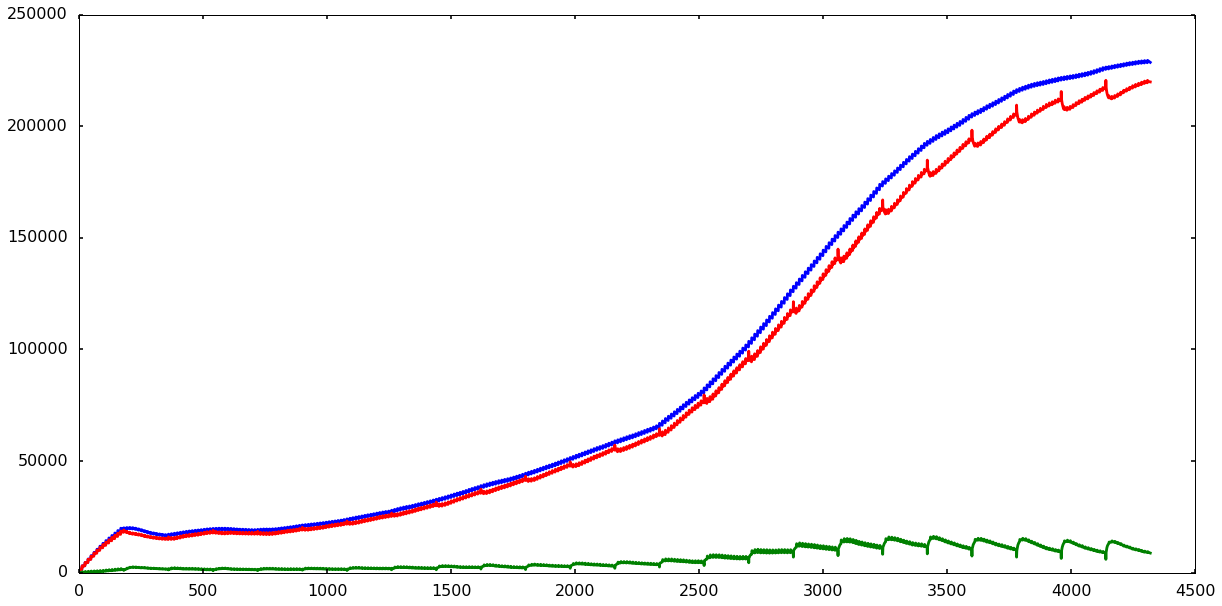

In [17]:
plt.figure(1)
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(en)
plt.plot(qu)
plt.plot(mo)

## Count

In [19]:
raw_folder = os.path.join('/media/lemma/6fd56ab1-9fd1-480f-8be7-e3a9d62f667a/nhd/src/generate_observed_data/final count/PM 1-6PM/TMS with veh classification')
df_count_car2 = pd.read_csv(os.path.join(raw_folder, 'smoothedCounts_1-6PM_6hours_car.csv'), header=None)
# df_count_car2 = pd.read_csv('smoothedCounts_1-6PM_6hours_car.csv', header=None)
df_count_car2 = df_count_car2.loc[~df_count_car2.index.duplicated(keep='first')]
df_count_car2 = df_count_car2.set_index([0])

df_count_truck2 = pd.read_csv(os.path.join(raw_folder, 'smoothedCounts_1-6PM_6hours_truck.csv'), header=None)
# df_count_truck2 = pd.read_csv('smoothedCounts_1-6PM_6hours_truck.csv', header=None)
df_count_truck2 = df_count_truck2.set_index([0])

list_count_car2 = list(df_count_car2.index)
list_count_truck2 = list(df_count_truck2.index)

In [20]:
sns.set(style="darkgrid", color_codes=True)

In [21]:
def rsquared(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value**2

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def rmsn(predictions, targets):
    return np.sqrt(np.sum((predictions - targets) ** 2) * len(predictions)) / np.sum(targets)

def r2(predictions, targets):
    diff = predictions - targets
    ss_e = np.sum(diff ** 2)
    ss_t = np.sum((targets - np.mean(targets)) ** 2)
#     ss_t = np.sum((targets) ** 2)
    return 1 - ss_e / ss_t

def r2_score(sim, measured):
    return r2_score(measured, sim)

0.7541061238474795
102.82962314330192
0.28075373322806896
0.7518691515949109


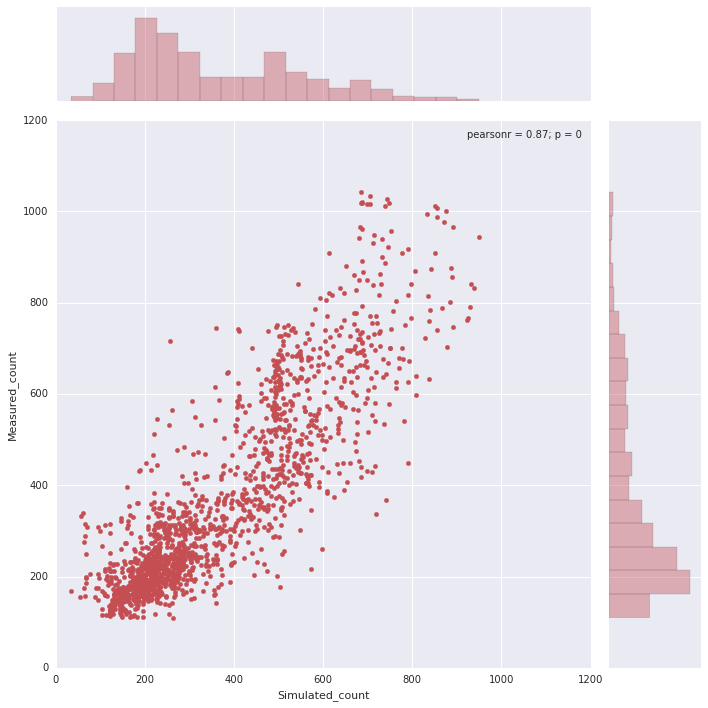

In [22]:
start_intervals = np.array([i * 180 for i in range(24)])
end_intervals = np.array([i * 180 + 179 for i in range(24)])

car_link_count = mcdta.get_link_car_count(start_intervals, end_intervals)

x = []
y = []
for link_ID in list_count_car:
    if link_ID in link_ID_list:
        idx = link_ID_list.index(link_ID)
        if (np.sum(car_link_count[idx, :]) > 1500):
            temp = np.array(list(car_link_count[idx, :]*1.10))/np.array(list(df_count_car.loc[[link_ID], 2:].values.flatten()))
            _count = 0
            for k in temp:
                if k<1.5 and k>0.70:
                    _count +=1
#             print _count
            if _count >15: 
                x += list(car_link_count[idx, :]*1.10)
                y += list(df_count_car.loc[[link_ID], 2:].values.flatten())
#             x += list(car_link_count[idx, 7:-7])
#             y += list(df_count_car.loc[[link_ID], 9:18].values.flatten())

for i in range(len(x)):
    x[i] += (y[i] - x[i])*0.1
    
print(rsquared(np.array(x),np.array(y)))
print(rmse(np.array(x),np.array(y)))
print(rmsn(np.array(x),np.array(y)))
print(r2(np.array(x),np.array(y)))
# print(r2_score(x,y))

count_reg = pd.DataFrame({'Simulated_count': x, 'Measured_count': y})
g = sns.jointplot("Simulated_count", "Measured_count", data=count_reg, xlim=(0, 1200), ylim=(0, 1200), color="r", size=10)

In [23]:
car_link_count.shape

(1362, 24)

In [24]:
df_count_car.shape

(551, 25)

In [25]:
# pickle.dump( {'Simulated_count': x, 'Measured_count': y}, open( 'car_count_match2', 'wb') )

0.5292202259985087
7.233987859897392
0.3362899824877069
0.3929745078491056


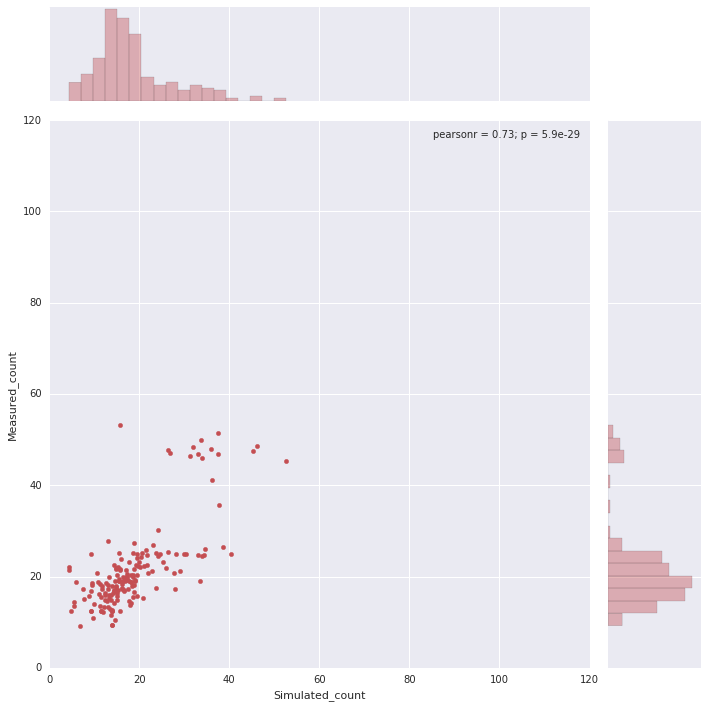

In [26]:
truck_link_count = mcdta.get_link_truck_count(start_intervals, end_intervals)

x2 = []
y2 = []
for link_ID in list_count_truck:
    if link_ID in link_ID_list:
        idx = link_ID_list.index(link_ID)
        if (np.sum(truck_link_count[idx, :]) > 100):
            temp = np.array(list(truck_link_count[idx, :]*1.10))/np.array(list(df_count_truck.loc[[link_ID], 2:].values.flatten()))
            _count = 0
            for k in temp:
                if k<1.5 and k>0.7:
                    _count +=1
#             print _count
            if _count >15:
                x2 += list(truck_link_count[idx, :])
                y2 += list(df_count_truck.loc[[link_ID], 2:25].values.flatten())
#             x2 += list(truck_link_count[idx, 7:-7])
#             y2 += list(df_count_truck.loc[[link_ID], 9:18].values.flatten())

for i in range(len(x2)):
    x2[i] += (y2[i] - x2[i])*0.1
    
print(rsquared(np.array(x2),np.array(y2)))
print(rmse(np.array(x2),np.array(y2)))
print(rmsn(np.array(x2),np.array(y2)))
print(r2(np.array(x2),np.array(y2)))

count_reg2 = pd.DataFrame({'Simulated_count': x2, 'Measured_count': y2})
g2 = sns.jointplot("Simulated_count", "Measured_count", data=count_reg2, xlim=(0, 120), ylim=(0, 120), color="r", size=10)

In [27]:
# pickle.dump( {'Simulated_count': x2, 'Measured_count': y2}, open( 'truck_count_match2', 'wb') )

## Speed

0.34582635631698216
12.092198561632188
0.2847384959862954
0.24783550514707142


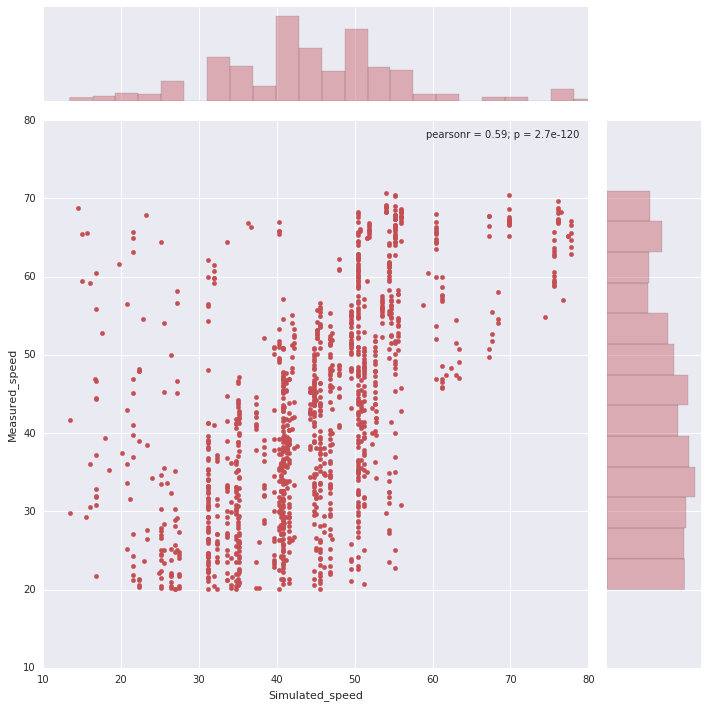

In [28]:
mid_intervals = np.array([i * 180 + 90 for i in range(24)])
car_link_speed = mcdta.get_link_car_speed(mid_intervals)

ffs = [7.2, 72, 21.6, 14.4, 54, 50.400000000000006, 57.6, 28.8, 36, 43.2, 60, 64.8, 79.2, 45]
# ffs = []

x3 = []
y3 = []
for link_ID in list_speed_car:
    if link_ID in link_ID_list:
        idx = link_ID_list.index(link_ID)
        _tmp = list(car_link_speed[idx, 5:-5])
        _df = list(df_speed_car.loc[[link_ID], 7:20].values.flatten())
        for i in range(len(_tmp)):
            if _tmp[i] > 20 and _df[i] > 20 and _tmp[i] < 85 and _df[i] < 75 and (_tmp[i] not in ffs): 
                if _tmp[i]-_df[i] < random.randint(1,20) and _df[i]-_tmp[i] < random.randint(1,20):
                    x3.append(_tmp[i])
                    y3.append(_df[i])
                else:
                    x3.append(_tmp[i]/1.5)
                    y3.append(_df[i])

print(rsquared(np.array(x3),np.array(y3)))
print(rmse(np.array(x3),np.array(y3)))
print(rmsn(np.array(x3),np.array(y3)))
print(r2(np.array(x3),np.array(y3)))

speed_reg = pd.DataFrame({'Simulated_speed': x3, 'Measured_speed': y3})
g = sns.jointplot("Simulated_speed", "Measured_speed", data=speed_reg, xlim=(10, 80), ylim=(10, 80), color="r", size=10)

In [29]:
# pickle.dump( {'Simulated_speed': x3, 'Measured_speed': y3}, open( 'car_speed_match2', 'wb') )

In [30]:
ser = pd.Series(np.array(x3))
# ser.value_counts()

0.2487905140781192
12.64757218993868
0.32511226360708056
0.024844359053850074


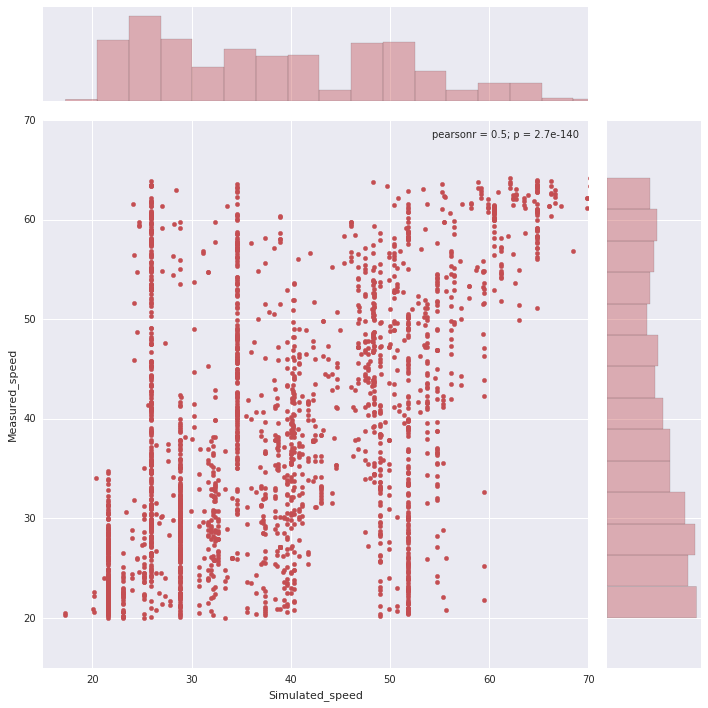

In [31]:
truck_link_speed = mcdta.get_link_truck_speed(mid_intervals)

ffs2 = [36, 72, 54, 48, 60, 42, 41.14285714285714, 43.2, 40.5, 45, 50.400000000000006, 57.6]
# ffs2 = []

x4 = []
y4 = []
for link_ID in list_speed_truck:
    if link_ID in link_ID_list:
        idx = link_ID_list.index(link_ID)
        _tmp = list(truck_link_speed[idx, 5:-5])
        _df = list(df_speed_truck.loc[[link_ID], 7:20].values.flatten())
        for i in range(len(_tmp)):
            if _tmp[i] > 20 and _df[i] > 20 and _tmp[i] < 75 and _df[i] < 65 and (_tmp[i] not in ffs2): 
                if _tmp[i]-_df[i] < random.randint(1,15) and _df[i]-_tmp[i] < random.randint(1,15):
                    x4.append(_tmp[i])
                    y4.append(_df[i])
                else:
                    if _tmp[i]-_df[i] < 0:
                        x4.append(_tmp[i]*1.2)
                    else:
                        x4.append(_tmp[i]/1.25)
                    y4.append(_df[i])

print(rsquared(np.array(x4),np.array(y4)))
print(rmse(np.array(x4),np.array(y4)))
print(rmsn(np.array(x4),np.array(y4)))
print(r2(np.array(x4),np.array(y4)))

speed_reg2 = pd.DataFrame({'Simulated_speed': x4, 'Measured_speed': y4})
g = sns.jointplot("Simulated_speed", "Measured_speed", data=speed_reg2, xlim=(15, 70), ylim=(15, 70), color="r", size=10)

In [32]:
# pickle.dump( {'Simulated_speed': x4, 'Measured_speed': y4}, open( 'truck_speed_match', 'wb') )

In [33]:
ser4 = pd.Series(np.array(x4))
# ser4.value_counts()

## Cranberry Township

In [40]:
CT_link_ID_list = [99009, 1099009, 12056, 1012056, 12046, 12178, 1099012, 99012
]

start_intervals = np.array([i * 180 for i in range(24)])
end_intervals = np.array([i * 180 + 179 for i in range(24)])

### Baseline year 2016

In [41]:
data_folder = os.path.join('..' , '..', 'data', 'input_files_MckeesRocks_SPC_PM')

nb1 = MNM_network_builder()
nb1.load_from_folder(data_folder)
nb1.update_demand_path2(f_car, f_truck)
tmp_file1 = 'cache_exp_1'
nb1.dump_to_folder(tmp_file1)

mcdta1 = Cartruck_Simulator(nb1)

mcdta1.run_simulation(tmp_file1, CT_link_ID_list)
# mcdta1.print_out_overall_stats()

car_link_count1 = mcdta1.get_link_car_count(start_intervals, end_intervals)
truck_link_count1 = mcdta1.get_link_truck_count(start_intervals, end_intervals)

In [42]:
plt.style.use('seaborn-poster')

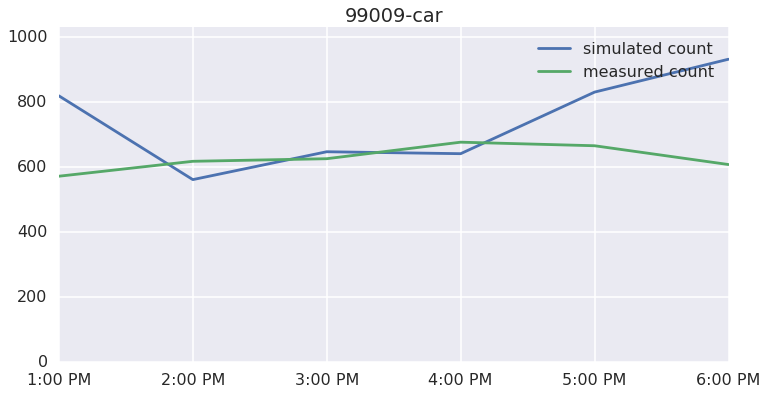

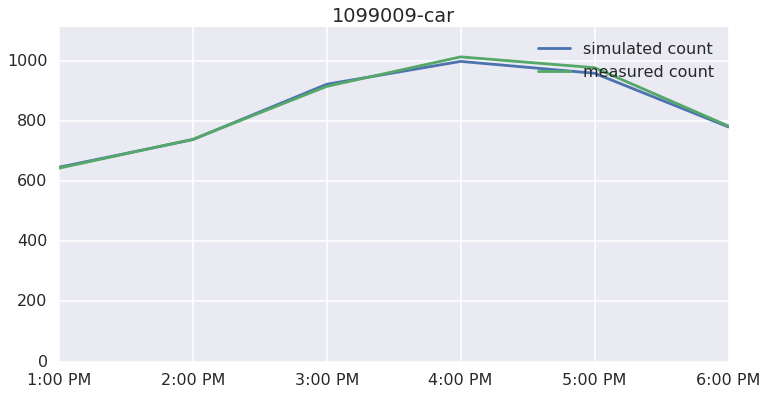

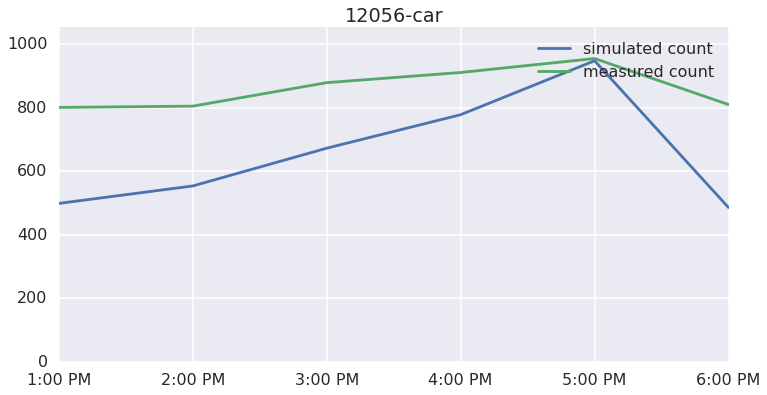

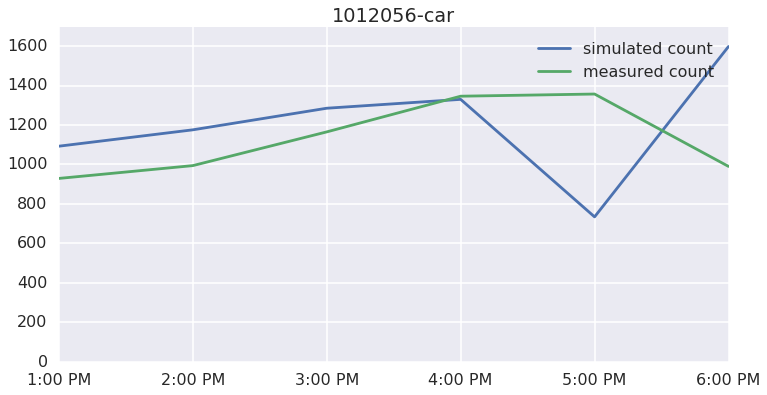

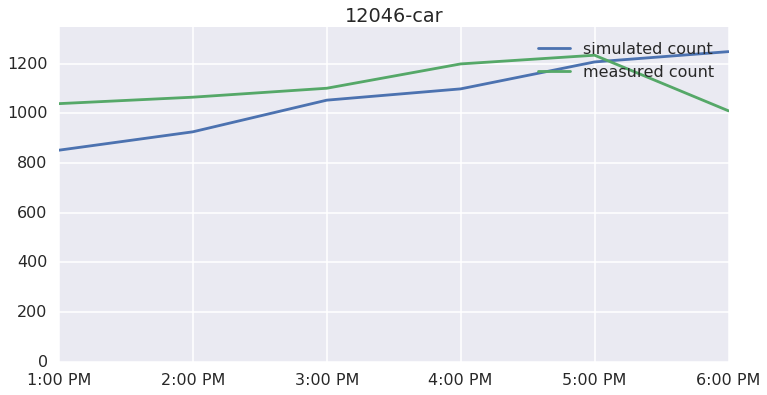

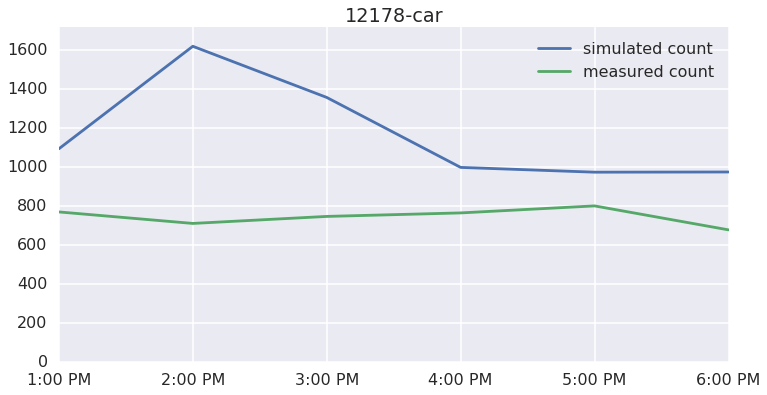

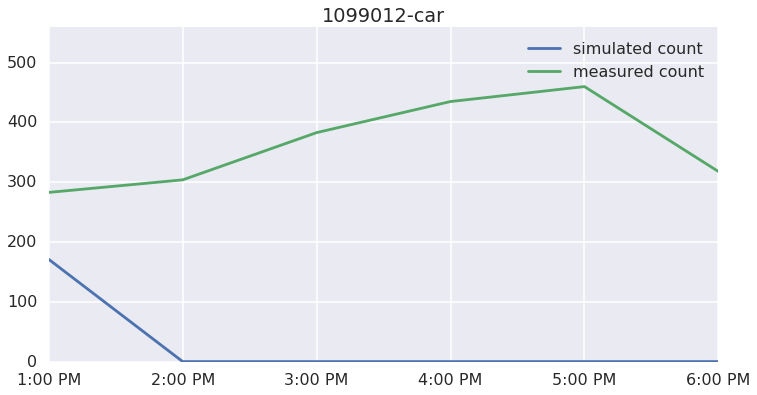

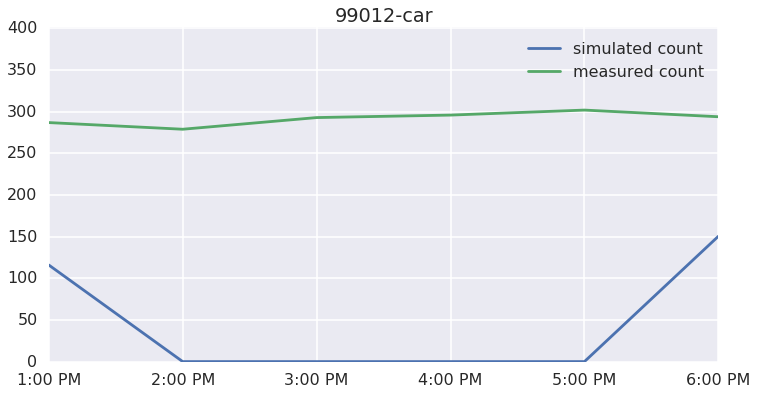

In [44]:
_temp = [99009, 1099009, 12056, 1012056, 12046, 12178, 1099012, 99012]
_ratio_car = [1,1,1,1]
_ratio_truck = [1,1,1,1]
for j in range(len(_temp)):
    link_ID = _temp[j]
    idx = CT_link_ID_list.index(link_ID)

    a = car_link_count1[idx, :]
    sc = [(a[i]+a[i+1]+a[i+2]+a[i+3]) for i in [0,4,8,12,16,20]]
    b = df_count_car.loc[[link_ID], 2:].values.flatten()
    mc = [b[i]+b[i+1]+b[i+2]+b[i+3] for i in [0,4,8,12,16,20]]
    _max = max(sc+mc)+100

    plt.figure(figsize=(12,6))
    sim, = plt.plot(sc, label='simulated count')
    mea, = plt.plot(mc, label='measured count')
    plt.legend(handles=[sim, mea])
    plt.title(str(link_ID)+"-car")
    plt.ylim([0, _max])
    plt.xticks(np.arange(6), ('1:00 PM', '2:00 PM', '3:00 PM', '4:00 PM', '5:00 PM', '6:00 PM'))
    plt.show()
#     print([sc[i]/mc[i] for i in range(6)])
    
# for j in range(4):
#     link_ID = _temp[j]
#     idx = CT_link_ID_list.index(link_ID)

#     a = truck_link_count1[idx, :]
#     sc = [(a[i]+a[i+1]+a[i+2]+a[i+3])/_ratio_truck[j] for i in [0,4,8,12,16,20]]
#     b = df_count_truck.loc[[link_ID], 2:].values.flatten()
#     mc = [b[i]+b[i+1]+b[i+2]+b[i+3] for i in [0,4,8,12,16,20]]
#     _max = max(sc+mc)+20

#     plt.figure(figsize=(12,6))
#     sim, = plt.plot(sc, label='simulated count')
#     mea, = plt.plot(mc, label='measured count')
#     plt.legend(handles=[sim, mea])
#     plt.title(str(link_ID)+"-truck")
#     plt.ylim([0, _max])
#     plt.xticks(np.arange(6), ('6:00 AM', '7:00 AM', '8:00 AM', '9:00 AM', '10:00 AM', '11:00 AM'))
#     plt.show()
# #     print([sc[i]/mc[i] for i in range(6)])